In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 미로 구현
초기상태

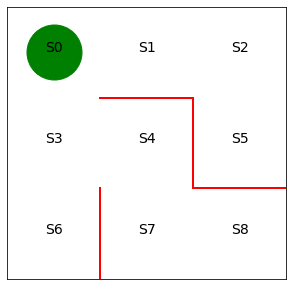

In [2]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()

#붉은 벽 그리기
plt.plot([1,1],[0,1], color='red', linewidth=2)
plt.plot([1,2],[2,2], color='red', linewidth=2)
plt.plot([2,2],[2,1], color='red', linewidth=2)
plt.plot([2,3],[1,1], color='red', linewidth=2)

#상태 문자열 표시
plt.text(0.5, 2.5, 'S0', size=14, ha = 'center')
plt.text(1.5, 2.5, 'S1', size=14, ha = 'center')
plt.text(2.5, 2.5, 'S2', size=14, ha = 'center')
plt.text(0.5, 1.5, 'S3', size=14, ha = 'center')
plt.text(1.5, 1.5, 'S4', size=14, ha = 'center')
plt.text(2.5, 1.5, 'S5', size=14, ha = 'center')
plt.text(0.5, 0.5, 'S6', size=14, ha = 'center')
plt.text(1.5, 0.5, 'S7', size=14, ha = 'center')
plt.text(2.5, 0.5, 'S8', size=14, ha = 'center')

# x,y축 범위 설정 및 눈금 제거
ax.set_xlim(0,3)
ax.set_ylim(0,3)
plt.tick_params(axis='both', which='both',bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

#시작점 표시
line, = ax.plot([0.5],[2.5], marker='o', color='g', markersize=55)

### 에이전트 구현

In [3]:
#정책을 결정하는 파라미터의 초깃값 theta_0을 설정
#row - 상태0~7, col - 행동(상,우,하,좌)

theta_0 = np.array([[np.nan, 1, 1, np.nan], #S0일 때 가능한 행동이면 1, 가능하지 않은 방향이면 nan
                     [np.nan, 1, np.nan, 1], #S1
                     [np.nan, np.nan, 1, 1], #S2
                     [1, 1, 1 , np.nan], #S3
                     [np.nan, np.nan, 1, 1], #4
                     [1, np.nan, np.nan, np.nan], #S5
                     [1, np.nan, np.nan, np.nan], #S6
                     [1, 1, np.nan, np.nan] #S7
                    ]) #S8은 목표지점이기 때문에 정책 없음

### ϵ-greedy algorithm으로 정책 구현하기

In [4]:
# 행동가치 함수 Q 행 - 상태 s, 열은 행동 a : Q(s,a)
# Q의 초기상태

[a,b] = theta_0.shape #열과 행의 개수를 변수 a,b에 저장
Q = np.random.rand(a,b) * theta_0
# * theta0으로 요소단위 곱셈을 수행, Q에서 벽방향으로 이동하는 행동에는 nan부여

In [5]:
#정책 파라미터 theta_0을 무작위 행동 정책 pi로 변환하는 함수
#epsilon으로 무작위 행동 취하고 나머지 확률로 1-epsilon은 Q값이 큰 행동을 취하도록 하고 epsilon은 점점 줄어들게하여
#explore-exploit trade off를 적절히 섞도록 한다

def simple_convert_into_pi_from_theta(theta):
    [m,n] = theta.shape
    pi = np.zeros((m,n))
    for i in range(0,m):
        pi[i,:] = theta[i,:] / np.nansum(theta[i,:]) #단순 비율 계산
    
    pi = np.nan_to_num(pi)
    return pi

#무작위 행동정책 pi_0을 계산
pi_0 = simple_convert_into_pi_from_theta(theta_0)

In [6]:
# ϵ-greedy 알고리즘 

#행동 결정
def get_action(s, Q, epsilon, pi_0):
    direction = ['up','right','down','left']
    
    #행동 결정
    if np.random.rand() < epsilon: #입실론 보다 작으면 랜덤 행동
        next_direction = np.random.choice(direction, p=pi_0[s,:])
        
    else: #그렇지 않으면 Q값이 최대가 되는 행동
        next_direction = direction[np.nanargmax(Q[s,:])]
        
    #행동을 인덱스로 변환
    if next_direction == 'up':
        action = 0
    elif next_direction == 'right':
        action = 1
    elif next_direction == 'down':
        action = 2
    elif next_direction == 'left':
        action = 3
    
    return action

#행동을 받고 다음 상태를 결정
def get_s_next(s,a,Q,epsilon, pi_0):
    direction = ['up','right','down','left']
    next_direction = direction[a] #행동 a의 방향
    
    #행동으로 다음 상태 결정
    if next_direction == 'up':
        s_next = s - 3
    elif next_direction == 'right':
        s_next = s + 1
    elif next_direction == 'down':
        s_next = s + 3
    elif next_direction == 'left':
        s_next = s -1
    
    return s_next

### 행동가치 함수 Q(s,a)를 Sarsa 알고리즘으로 수정

In [7]:
#행동가치 함수 Q를 학습하기 위해 Sarsa알고리즘의 적용

def Sarsa(s, a, r, s_next, a_next, Q, eta, gamma):
    
    if s_next == 8: #목표 지점에 도착하면 다음 상태 존재 X
        Q[s,a] = Q[s,a] + eta * (r-Q[s,a])
    else :
        Q[s,a] = Q[s,a] + eta * (r+gamma*Q[s_next, a_next] - Q[s,a])
        
    return Q

### Sarsa로 미로찾기 구현
가치반복 알고리즘에서는 정책경사 알고리즘과 달리, 매 시행이 업데이트의 단위가 아니라 매 단계(한 액션)가 단위가 된다

In [8]:
def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0 
    a = a_next = get_action(s,Q, epsilon, pi) #첫번째 행동
    s_a_history = [[0,np.nan]]
    
    while(1):
        a = a_next
        s_a_history[-1][1] = a
        s_next = get_s_next(s,a,Q,epsilon,pi) #현재 상태에서 행동 함수를 통해 다음 단계의 상태 구하고
        s_a_history.append([s_next, np.nan])
        
        #다음 상태의 결과에 따라 보상을 부여하고 다음 행동을 계산
        if s_next == 8:
            r = 1
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
        
        #보상을 받은 것을 고려하여 가치함수를 수정
        Q = Sarsa(s, a, r, s_next, a_next, Q, eta, gamma)
        
        #종료 여부 판단
        if s_next == 8: break
        else: s = s_next 
            
    return [s_a_history, Q]

In [9]:
# 함수들 전체 실행 코드

eta = 0.1 #학습률
gamma = 0.9 #시간할인률
epsilon = 0.5 # 입실론 그리디 알고리즘에서 입실론 초기값
v = np.nanmax(Q, axis = 1) #각 상태마다 가치의 최댓값 계산
is_continue = True
episode = 1

while is_continue:
    print("current episode num:",episode)
    
    #한번 에피소드 마다 입실론 값 감소해서 랜덤의 비율 점점 줄이기
    epsilon = epsilon/2
    
    #Sarsa알고리즘으로 미로를 빠져나온 후, 결과로 나온 행동 히스토리와 Q값을 변수에 저장
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)
    
    #상태가치의 변화
    new_v = np.nanmax(Q, axis = 1) #각 상태마다 행동가치의  최대값을 계산
    print(np.sum(np.abs(new_v - v))) #상태가치 함수의 변화를 출력
    v = new_v
    
    print('목표 지점까지 걸린 단계 수는',len(s_a_history)-1, '단계입니다.')
    
    episode += 1
    if episode >100: break

current episode num: 1
1.181017146581631
목표 지점까지 걸린 단계 수는 60 단계입니다.
current episode num: 2
0.37754674652190956
목표 지점까지 걸린 단계 수는 88 단계입니다.
current episode num: 3
0.41566717095547856
목표 지점까지 걸린 단계 수는 66 단계입니다.
current episode num: 4
0.07665207912239219
목표 지점까지 걸린 단계 수는 6 단계입니다.
current episode num: 5
0.08207763958850317
목표 지점까지 걸린 단계 수는 8 단계입니다.
current episode num: 6
0.07336259430707781
목표 지점까지 걸린 단계 수는 8 단계입니다.
current episode num: 7
0.07161572282200629
목표 지점까지 걸린 단계 수는 8 단계입니다.
current episode num: 8
0.06221098661349023
목표 지점까지 걸린 단계 수는 6 단계입니다.
current episode num: 9
0.06830070416597761
목표 지점까지 걸린 단계 수는 8 단계입니다.
current episode num: 10
0.06595429746010395
목표 지점까지 걸린 단계 수는 8 단계입니다.
current episode num: 11
0.05630360984642874
목표 지점까지 걸린 단계 수는 6 단계입니다.
current episode num: 12
0.05409042369442929
목표 지점까지 걸린 단계 수는 6 단계입니다.
current episode num: 13
0.045029230880940074
목표 지점까지 걸린 단계 수는 4 단계입니다.
current episode num: 14
0.047034922328995254
목표 지점까지 걸린 단계 수는 6 단계입니다.
current episode num: 15
0.